In [1]:
import os
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt

****Introduction****

This notebook has the purpose of assigning an analysis unit to each one of the images that will be used for the clustering.

First, the provided data is loaded.

In [41]:
project_name = 'Delft'
image_features_folder = r'Data\Delft\image_features'
network_data_path = r'C:\Users\lange\OneDrive\Documenten\Jaar_5-Msc_CE_TTE\DSAIE_STREETS\Data_old\Delft_NL'

In [27]:
# Load data
panoids = gpd.read_file(f"{network_data_path}\\panoids\\panoids.geojson", columns=['panoid', 'year', 'im_front', 'im_back'])
panoids = panoids.to_crs('EPSG:28992')

network_total = gpd.read_file(f"{network_data_path}\\network\\edges\\edges.geojson", columns=['level_0'])
network_total = network_total.rename(columns={'level_0': 'section_id'})
network_total = network_total.to_crs('EPSG:28992')

edges_drive = gpd.read_file(f"{network_data_path}\\network_data\\edges_drive.geojson", columns=['osmid'])
edges_drive = edges_drive.to_crs('EPSG:28992')

Skipping field lanes: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field highway: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5


Choose which network to match images to

In [28]:
name = 'edges_drive'
network = edges_drive
id_column = 'osmid'

In [29]:
def match_panoids_to_sections(panoids: gpd.GeoDataFrame, network: gpd.GeoDataFrame, maximum_distance: int):
    network_panoids =  {key: [] for key in network[id_column].values}

    count = 0
    for _, panoid in panoids.iterrows():
        panoid_point = panoid['geometry']

        network_i = network.cx[panoid_point.x-maximum_distance:panoid_point.x+maximum_distance,
                               panoid_point.y-maximum_distance:panoid_point.y+maximum_distance].copy()
        network_i['distance'] = network_i.distance(panoid_point)

        network_i = network_i[network_i['distance'] <= maximum_distance].copy()
        if len(network_i) > 0:
            network_i.sort_values(by=['distance'])
            network_panoids[network_i[id_column].values[0]].append(panoid['panoid'])
            count += 1
    print(f"Matched {count} out of {len(panoids)} paniods to network sections")

    count = 0
    for value in network_panoids.values():
        if value != []:
            count += 1
    print(f"{count} out of {len(network)} network sections have had panoids assigned")

    return network_panoids


In [30]:
network_panoids = match_panoids_to_sections(panoids, network, 20)

Matched 31320 out of 35856 paniods to network sections
1541 out of 5785 network sections have had panoids assigned


<Axes: >

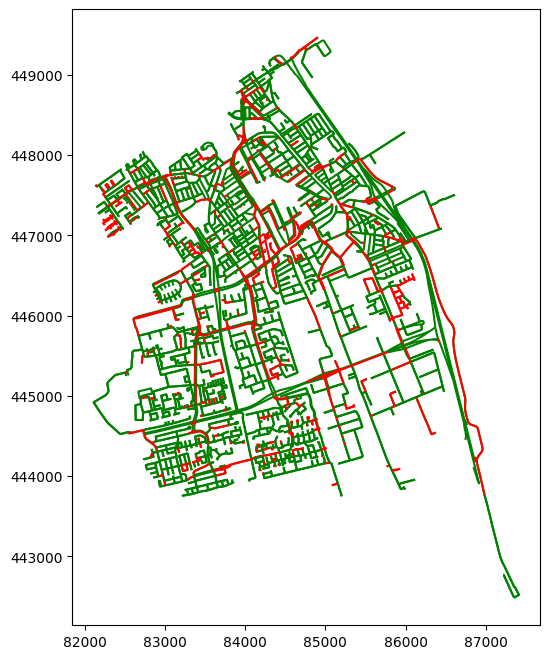

In [6]:
edges_drive['color'] = ['g' if len(network_panoids[section_id]) > 0 else 'r' for section_id in network[id_column]]

fig, ax = plt.subplots(figsize=(8,8))
edges_drive.plot(ax=ax, color=edges_drive['color'])

In [44]:
def assign_images_to_sections(network_panoids: dict[str, list[str]], panoids: gpd.GeoDataFrame,
                              image_features_folder: str) -> dict[str, list[str]]:
    network_images =  {key: [] for key in network_panoids}

    for section_id, panoid_ids in network_panoids.items():
        for panoid_id in panoid_ids:
            panoid = panoids[panoids['panoid'] == panoid_id]
            for image in [panoid['im_back'].values[0], panoid['im_front'].values[0]]:
                if os.path.exists(rf"{image_features_folder}\{image}.npy"):
                    network_images[section_id].append(image)
                else:
                    print(f"WARNING: features of '{image}' not found in given features folder, will be skipped")
    
    to_delete = []
    for section_id, images in network_images.items():
        if images == []:
            to_delete.append(section_id)

    for delete_id in to_delete:
        del network_images[delete_id]

    print(f"{len(network_images)} out of {len(network_panoids)} network sections have had images assigned")
    return network_images

In [45]:
network_images = assign_images_to_sections(network_panoids, panoids, image_features_folder)

1541 out of 2550 network sections have had images assigned


<Axes: >

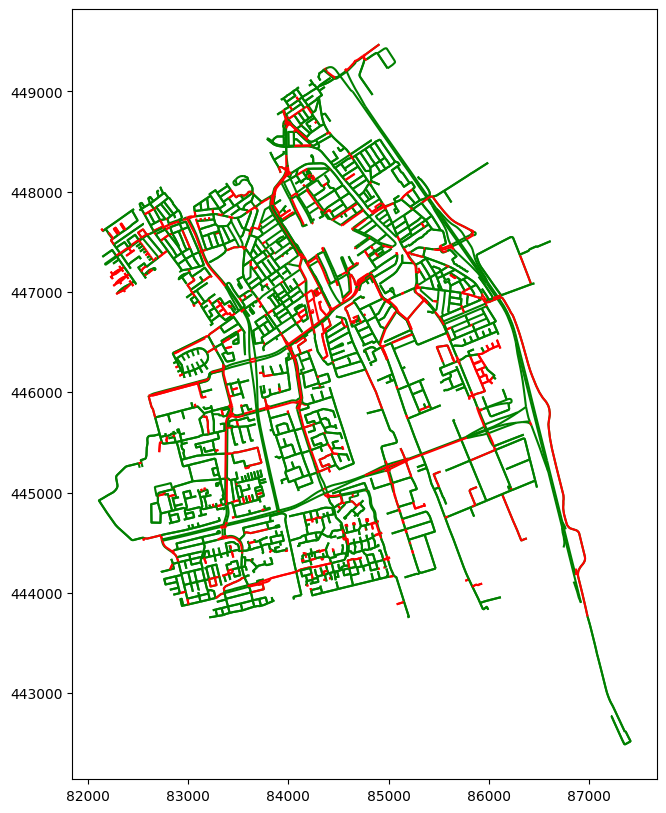

In [46]:
edges_drive['color'] = ['g' if section_id in network_images else 'r' for section_id in edges_drive['osmid']]

fig, ax = plt.subplots(figsize=(10,10))
edges_drive.plot(ax=ax, color=edges_drive['color'])

In [47]:
print(f"Saved network image assignment to 'Data\\{project_name}\\network_images.pkl'")
with open(f"Data\\{project_name}\\{name}_image_assignments.pkl", 'wb') as f:
    pickle.dump(network_images, f)

Saved network image assignment to 'Data\Delft\network_images.pkl'
